In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from src.paths import LOCAL_RAW_DATA_PATH

class_filter = 'RELEVANT' # possible values: "OTHERS", "RELEVANT", "FULL"
col_breakdown = 'index' # possible: "index", "real_class_name", "relationship" (index = real_class_name | relationship)

classes = {
    "1": "per:positive_impression",
    "2": "per:negative_impression",
    "3": "per:acquaintance",
    "4": "per:alumni",
    "5": "per:boss",
    "6": "per:subordinate",
    "7": "per:client",
    "8": "per:dates",
    "9": "per:friends",
    "10": "per:girl/boyfriend",
    "11": "per:neighbor",
    "12": "per:roommate",
    "13": "per:children",
    "14": "per:other_family",
    "15": "per:parents",
    "16": "per:siblings",
    "17": "per:spouse",
    "18": "per:place_of_residence",
    "19": "per:place_of_birth",
    "20": "per:visited_place",
    "21": "per:origin",
    "22": "per:employee_or_member_of",
    "23": "per:schools_attended",
    "24": "per:works",
    "25": "per:age",
    "26": "per:date_of_birth",
    "27": "per:major",
    "28": "per:place_of_work",
    "29": "per:title",
    "30": "per:alternate_names",
    "31": "per:pet",
    "32": "gpe:residents_of_place",
    "34": "gpe:visitors_of_place",
    "35": "org:employees_or_members",
    "36": "org:students",
    # "37": "unanswerable"
}


relationship_mapping = {
    'per:acquaintance': 'ACQUAINTANCE',
    'per:children': 'PARENT',  # assuming the children class is a reverse relationship of parent
    'per:parents': 'PARENT',
    'per:siblings': 'SIBLING',
    'per:spouse': 'SPOUSE',
    'per:place_of_residence': 'PLACE_OF_RESIDENCE',
    'per:visited_place': 'VISITED',
    'per:origin': 'PLACE_OF_BIRTH',  # assuming origin refers to the place of birth
    'per:employee_or_member_of': 'MEMBER_OF',
    'per:date_of_birth': 'PLACE_OF_BIRTH',  # date_of_birth would usually be an attribute, not a relationship, but I'm assuming you want it mapped to place_of_birth here
    'per:place_of_birth': 'PLACE_OF_BIRTH',  # date_of_birth would usually be an attribute, not a relationship, but I'm assuming you want it mapped to place_of_birth here
    'per:pet': 'PET',
    'gpe:residents_of_place': 'PLACE_OF_RESIDENCE',  # assuming this refers to people residing in a place
    'gpe:visitors_of_place': 'VISITED',  # assuming this refers to people who visited a place
}


classes = {
    int(k) - 1: v for k,v in classes.items()
}


filtered_classes = {
    k: v for k,v in classes.items()
    if any([g in v for g in (
        'pet', 'reside', 'birth', 'origin', 'sibling', 'acqu',
        'spous', 'parent', 'child', 'member_of', 'visit')
    ])}
filtered_classes

# Use glob to get a list of file paths matching the pattern
file_paths = glob.glob(str(LOCAL_RAW_DATA_PATH / 'reports/dialog-re-class-breakdown-wandb/wandb_export_*'))

# Create an empty list to store DataFrames
dfs = []

# Iterate through the file paths
for file_path in file_paths:
    # Read each file as a DataFrame and append it to the list
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Prefilter the DataFrame for epoch 8
prefiltered_df = combined_df[combined_df['epoch'] == 8]

# Create a list to store the columns to keep in the filtered DataFrame
columns_to_keep = []

# Iterate through the filtered_classes dictionary
for class_id, class_label in classes.items():
    # Generate the column names for precision, recall, and f1 score for the current class
    precision_column = f'noble-shadow-43 - class_{class_id:02d}/precision'
    recall_column = f'noble-shadow-43 - class_{class_id:02d}/recall'
    f1_column = f'noble-shadow-43 - class_{class_id:02d}/f1'

    # Add the column names to the list of columns to keep
    columns_to_keep.extend([precision_column, recall_column, f1_column])

# Filter the prefiltered DataFrame to keep only the desired columns
filtered_df = prefiltered_df[columns_to_keep]

# Assuming you have the filtered DataFrame stored in the variable 'filtered_df'

# Remove the run name from the columns
filtered_df_cleaned = filtered_df

# Remove the run name
filtered_df_cleaned.columns = [col.split(' - ')[-1] for col in filtered_df_cleaned.columns]

filtered_df_cleaned = filtered_df_cleaned.reset_index().drop('index', axis=1)

filtered_df_cleaned = filtered_df_cleaned.T

df = filtered_df_cleaned.copy()

tmp = df.copy()
i_col = [
    (0, 'f1'),
    (1, 'recall'),
    (2, 'precision')
]

output_data = {}
for (i, metric) in i_col:
  mask = tmp.index.str.contains(metric)
  tmp[metric] = tmp[mask][i]
  tmp = tmp.drop(i, axis=1)

  tmp2 = tmp[metric].dropna()
  tmp2.index = tmp2.index.str.replace(f'/{metric}', '')
  output_data[metric] = tmp2.to_dict()

df2 = pd.DataFrame(output_data)

# create a function to extract class ID from the index
def extract_class_id(s):
    return int(s.split("_")[-1])

# use the function to create a new column 'class_id'
df2['class_id'] = df2.index.map(extract_class_id)

# map the class_id to the real class names and create a new column 'real_class_name'
df2['real_class_name'] = df2['class_id'].map(classes)

# drop the 'class_id' column as it's not needed anymore
df2.drop('class_id', axis=1, inplace=True)


# Add a new column 'relationship' to df2
df2['relationship'] = df2['real_class_name'].map(lambda x: relationship_mapping.get(x, 'OTHERS'))

df2 = df2[['real_class_name', 'relationship', 'f1', 'precision', 'recall']]

df2 = df2.sort_values(['f1'], ascending=[False])

df2['index'] = df2.apply(lambda row: f"{row['real_class_name']} / {row['relationship']}", axis=1)

df2 = df2.sort_values('f1', ascending=False)


if class_filter == 'OTHERS':
  mask = df2['relationship'] == 'OTHERS'
  tmp = df2[mask]
elif class_filter == 'RELEVANT':
  mask = df2['relationship'] != 'OTHERS'
  tmp = df2[mask]
elif class_filter == 'FULL':
  tmp = df2
else:
  raise Exception('This is not a valid value for `class_filter`')

df2


,real_class_name,relationship,f1,precision,recall,index
class_27,per:place_of_work,OTHERS,1.000000,1.000000,1.000000,per:place_of_work / OTHERS
class_28,per:title,OTHERS,0.924855,0.919540,0.930233,per:title / OTHERS
class_20,per:origin,PLACE_OF_BIRTH,0.857143,1.000000,0.750000,per:origin / PLACE_OF_BIRTH
class_24,per:age,OTHERS,0.827586,0.857143,0.800000,per:age / OTHERS
class_23,per:works,OTHERS,0.814815,0.733333,0.916667,per:works / OTHERS
class_29,per:alternate_names,OTHERS,0.742917,0.651934,0.863415,per:alternate_names / OTHERS
class_33,gpe:visitors_of_place,VISITED,0.717949,0.736842,0.700000,gpe:visitors_of_place / VISITED
class_08,per:friends,OTHERS,0.685714,0.679245,0.692308,per:friends / OTHERS
class_19,per:visited_place,VISITED,0.666667,0.684211,0.650000,per:visited_place / VISITED
class_09,per:girl/boyfriend,OTHERS,0.603077,0.632258,0.576471,per:girl/boyfriend / OTHERS


f1           0.374863
precision    0.446218
recall       0.359009
dtype: float64


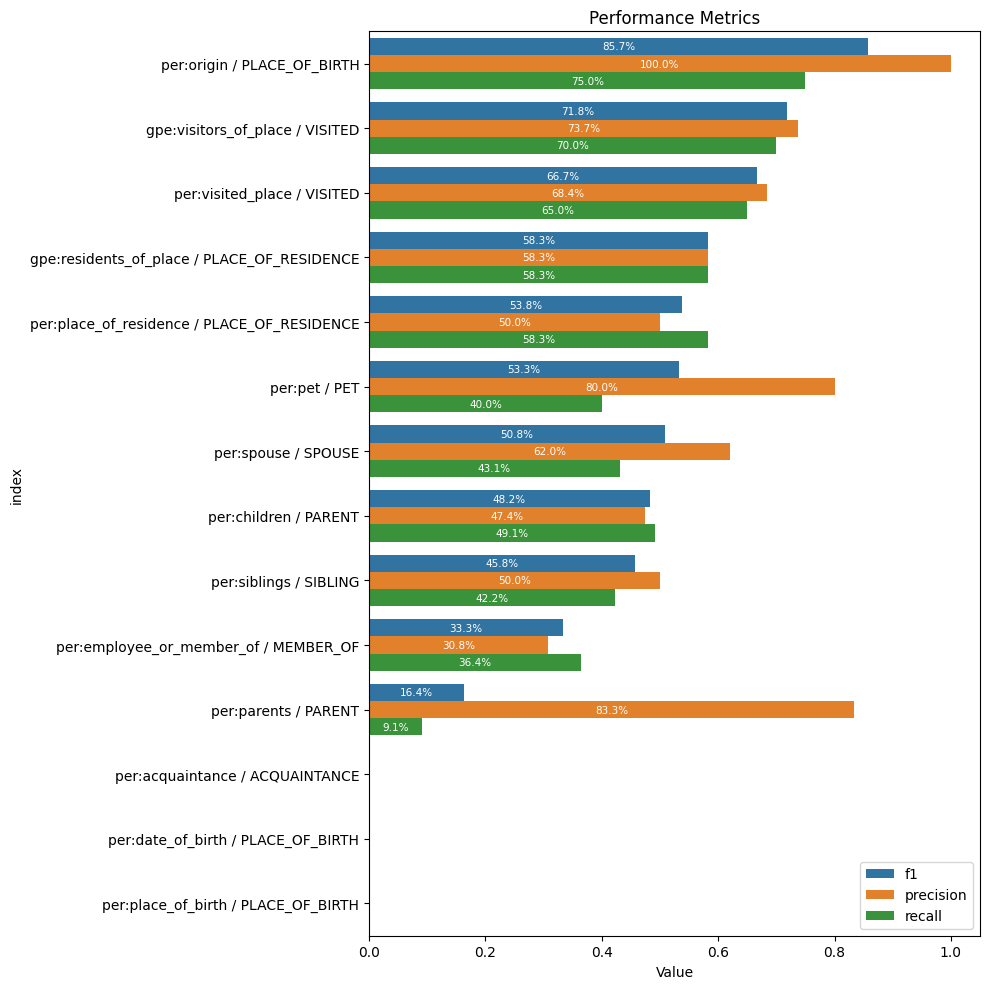

In [2]:
print(df2.mean(numeric_only=True))

# Transform df2 from wide to long format
df_melted = tmp.melt(id_vars=col_breakdown, value_vars=['f1', 'precision', 'recall'], var_name='Metric', value_name='Value')

# Sort dataframe by label (which is ordered according to F1 score)
# df_melted.sort_values(['label', 'Metric'], ascending=[False, True], inplace=True)

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Use seaborn to create the horizontal bar plot
sns.barplot(x='Value', y=col_breakdown, hue='Metric', data=df_melted, ax=ax)

# Add text labels in the center of each bar
for p in ax.patches:
    width = p.get_width()
    if width > 0:  # Skip null values
        plt.text(p.get_x()+width/2.,
                 p.get_y()+p.get_height()/2.,
                 '{:.1%}'.format(width),
                 ha='center',
                 va='center',
                 color='white',
                 fontsize=7.5)  # Adjust font size here


# Set the title and show the legend
ax.set_title('Performance Metrics')
ax.legend(loc='lower right')  # Set legend location to bottom right

plt.tight_layout()
plt.show()
